In [1]:
import os
import sys
import torch
import subprocess
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
    version_str="".join([
        f"py3{sys.version_info.minor}_cu",
        torch.version.cuda.replace(".",""),
        f"_pyt{pyt_version_str}"
    ])
    !pip install iopath
    if sys.platform.startswith("linux"):
        print("Trying to install wheel for PyTorch3D")
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
        pip_list = !pip freeze
        need_pytorch3d = not any(i.startswith("pytorch3d==") for  i in pip_list)
    if need_pytorch3d:
        print(f"failed to find/install wheel for {version_str}")
if need_pytorch3d:
    print("Installing PyTorch3D from source")
    !pip install ninja
    !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [2]:
# Import necessary libraries
import numpy as np
from tqdm.notebook import tqdm
import imageio
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage import img_as_ubyte
from IPython.display import clear_output
import torch.multiprocessing as mp
from tqdm import tqdm
import torch

# io utils
from pytorch3d.io import load_obj

# datastructures
from pytorch3d.structures import Meshes

# 3D transformations functions
from pytorch3d.transforms import Rotate, Translate

# rendering components
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation,
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex,
)

In [20]:
# Set the cuda device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
    print("GPU")
else:
    device = torch.device("cpu")
    print("CPU")

GPU


In [4]:
# Load the mesh (clipMesh.obj)
verts, faces_idx, _ = load_obj("/home/exouser/pose_estim/clipestimator/data/mesh/clipMesh.obj")
faces = faces_idx.verts_idx

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = TexturesVertex(verts_features=verts_rgb.to(device))

# Create a Meshes object for the clipMesh.
clip_mesh = Meshes(
    verts=[verts.to(device)],
    faces=[faces.to(device)],
    textures=textures
)

/home/exouser/anaconda3/envs/blvenv/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:550: UserWarning: Mtl file does not exist: /home/exouser/pose_estim/clipestimator/data/mesh/Item.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


In [27]:
# Initialize a perspective camera.
cameras = FoVPerspectiveCameras(device=device)

# Set blend parameters for silhouette rendering
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

# Rasterization settings for silhouette rendering
raster_settings_silhouette = RasterizationSettings(
    image_size=128,  # Match the reference image size
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma,
    faces_per_pixel=25,
    bin_size=0,
)

# Silhouette renderer
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)

# Rasterization settings for Phong rendering (for visualization)
raster_settings_phong = RasterizationSettings(
    image_size=128,  # Match the reference image size
    blur_radius=0.0,
    faces_per_pixel=1,
    bin_size=0,
)

# Lighting settings for Phong rendering
lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))

# Phong renderer
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings_phong
    ),
    shader=HardPhongShader(device=device, cameras=cameras, lights=lights)
)


In [28]:
# Select the viewpoint using spherical angles
distance = 30   # distance from camera to the object
elevation = 15.0   # angle of elevation in degrees
azimuth = 150.0  # No rotation so the camera is positioned on the +Z axis.

# Get the position of the camera based on the spherical angles
R_t, T_t = look_at_view_transform(distance, elevation, azimuth, device=device)
print(R_t, T_t)

tensor([[[ 0.8660, -0.1294, -0.4830],
         [-0.0000,  0.9659, -0.2588],
         [ 0.5000,  0.2241,  0.8365]]], device='cuda:0') tensor([[-0.0000e+00, 4.7684e-07, 3.0000e+01]], device='cuda:0')


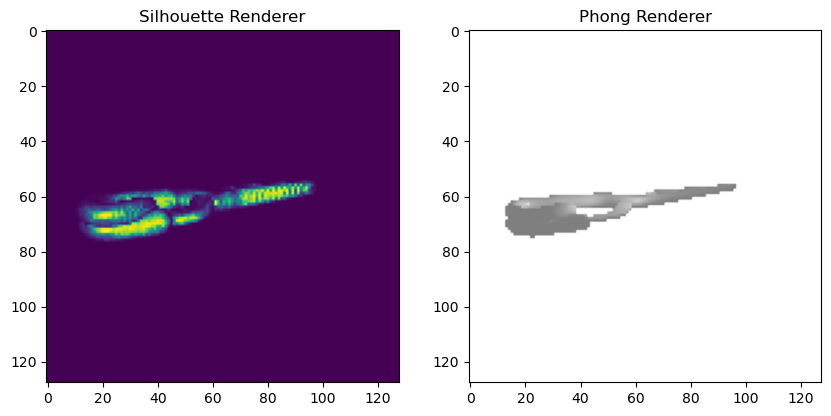

In [30]:
# Render the mesh providing the values of R and T.
silhouette = silhouette_renderer(meshes_world=clip_mesh, R=R_t, T=T_t)
image_ref = phong_renderer(meshes_world=clip_mesh, R=R_t, T=T_t)

silhouette = silhouette.cpu().numpy()
image_ref = image_ref.cpu().numpy()

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(silhouette.squeeze()[..., 3])  # only plot the alpha channel of the RGBA image
plt.title("Silhouette Renderer")
plt.grid(False)
plt.subplot(1, 2, 2)
plt.imshow(image_ref.squeeze())
plt.title("Phong Renderer")
plt.grid(False)

In [31]:
class Model(nn.Module):
    def __init__(self, meshes, renderer, image_ref):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.renderer = renderer
        
        # Get the silhouette of the reference RGB image by finding all non-white pixel values. 
        image_ref = torch.from_numpy((image_ref[..., :3].max(-1) != 1).astype(np.float32))
        self.register_buffer('image_ref', image_ref)
        
        # Create an optimizable parameter for the x, y, z position of the camera. 
        self.camera_position = nn.Parameter(
            torch.from_numpy(np.array([20.0,  20.0, +20.0], dtype=np.float32)).to(meshes.device))

    def forward(self):
        
        # Render the image using the updated camera position. Based on the new position of the 
        # camera we calculate the rotation and translation matrices
        R = look_at_rotation(self.camera_position[None, :], device=self.device)  # (1, 3, 3)
        T = -torch.bmm(R.transpose(1, 2), self.camera_position[None, :, None])[:, :, 0]   # (1, 3)
        
        image = self.renderer(meshes_world=self.meshes.clone(), R=R, T=T)
        
        # Calculate the silhouette loss
        loss = torch.mean((image[..., 3] - self.image_ref) ** 2)
        return loss, image

In [32]:
# We will save images periodically and compose them into a GIF.
#filename_output = "./teapot_optimization_demo.gif"
#writer = imageio.get_writer(filename_output, mode='I', duration=0.3)

# Initialize a model using the renderer, mesh and reference image
model = Model(meshes=clip_mesh, renderer=silhouette_renderer, image_ref=image_ref).to(device)

# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
#optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

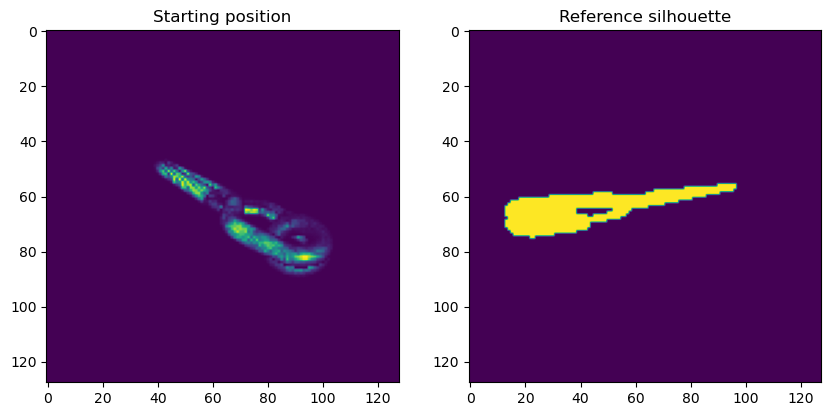

In [33]:
plt.figure(figsize=(10, 10))

_, image_init = model()
plt.subplot(1, 2, 1)
plt.imshow(image_init.detach().squeeze().cpu().numpy()[..., 3])
plt.grid(False)
plt.title("Starting position")

plt.subplot(1, 2, 2)
plt.imshow(model.image_ref.cpu().numpy().squeeze())
plt.grid(False)
plt.title("Reference silhouette");

plt.show()

In [13]:
# Function to generate a random camera position within a safe distance
def random_camera_position(min_distance, max_distance, device):
    distance = np.random.uniform(min_distance, max_distance)
    azimuth = np.random.uniform(0, 180)  # Degrees
    elevation = np.random.uniform(-90, 90)  # Degrees
    x = distance * np.cos(np.radians(elevation)) * np.cos(np.radians(azimuth))
    y = distance * np.cos(np.radians(elevation)) * np.sin(np.radians(azimuth))
    z = distance * np.sin(np.radians(elevation))
    return torch.tensor([x, y, z], device=device, dtype=torch.float32)

# Function to generate a new camera position near a given reference position
def random_nearby_position(reference_position, deviation, device):
    noise = np.random.uniform(-deviation, deviation, size=(3,))  # Generate random noise in x, y, z
    new_position = reference_position.cpu().numpy() + noise  # Apply noise to the reference position
    return torch.tensor(new_position, device=device, dtype=torch.float32)  # Convert to tensor on the correct device

# Function to generate diverse test target positions
def generate_target_positions(min_distance, max_distance, num_points):
    azimuths = np.random.uniform(0, 180, num_points)  # Random azimuth angles in degrees
    elevations = np.random.uniform(-90, 90, num_points)  # Random elevations in degrees
    distances = np.random.uniform(min_distance, max_distance, num_points)  # Random distances

    target_positions = []
    for i in range(num_points):
        az, el, d = azimuths[i], elevations[i], distances[i]
        x = d * np.cos(np.radians(el)) * np.cos(np.radians(az))
        y = d * np.cos(np.radians(el)) * np.sin(np.radians(az))
        z = d * np.sin(np.radians(el))
        target_positions.append([x, y, z])

    return torch.tensor(target_positions, dtype=torch.float32)


# Function to optimize camera position for a given target
def optimize_camera_position(target_position, device):
    num_initial_restarts = 15
    num_refined_restarts = 5
    num_iterations_min = 200
    num_iterations_max = 400
    patience = 20
    significant_improvement = 0.001
    nearby_deviation = 5.0

    best_loss = float('inf')
    best_camera_position = None

    # Initial Random Restarts
    all_restart_results = []
    for restart in range(num_initial_restarts):
        model.camera_position.data = random_camera_position(40, 50, device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
        loss_values = []
        prev_loss = float('inf')
        no_improve_counter = 0

        for i in range(num_iterations_max):
            optimizer.zero_grad()
            loss, _ = model()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            loss_values.append(loss.item())

            if loss.item() >= prev_loss - significant_improvement:
                no_improve_counter += 1
            else:
                no_improve_counter = 0  # Reset counter if improvement is significant
            prev_loss = loss.item()

            if no_improve_counter >= patience and i >= num_iterations_min:
                break  # Early stopping

        # Save restart results
        restart_result = {
            'restart_id': restart,
            'final_loss': loss_values[-1],
            'camera_position': model.camera_position.data.clone(),
            'loss_values': loss_values
        }
        all_restart_results.append(restart_result)

        # Update best model
        if loss_values[-1] < best_loss:
            best_loss = loss_values[-1]
            best_camera_position = model.camera_position.data.clone()

    # Identify the best initial restart
    best_initial_restart = min(all_restart_results, key=lambda x: x['final_loss'])

    # Refined Restarts near the best initial restart
    for restart in range(num_refined_restarts):
        model.camera_position.data = random_nearby_position(best_initial_restart['camera_position'], nearby_deviation, device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.05)  # Lower LR for fine-tuning
        loss_values = []
        prev_loss = float('inf')
        no_improve_counter = 0

        for i in range(num_iterations_max):
            optimizer.zero_grad()
            loss, _ = model()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            loss_values.append(loss.item())

            if loss.item() >= prev_loss - significant_improvement:
                no_improve_counter += 1
            else:
                no_improve_counter = 0  # Reset counter if improvement is significant
            prev_loss = loss.item()

            if no_improve_counter >= patience and i >= num_iterations_min:
                break  # Early stopping

        # Update best model
        if loss_values[-1] < best_loss:
            best_loss = loss_values[-1]
            best_camera_position = model.camera_position.data.clone()

    # Compute deviation/error
    estimated_position = best_camera_position
    error = torch.norm(estimated_position - target_position.to(device)).item()

    return {
        "target_pos": target_position.cpu().numpy(),
        "estimated_pos": estimated_position.cpu().numpy(),
        "final_loss": best_loss,
        "error": error
    }

# Function to compute atomic error for a given optimization result
def compute_atomic_error(best_camera_position, target_position, model, clip_mesh):
    scale_factor = 1.0  # Adjust to match desired unit system

    # Step 1: Get the bounding box of the target mesh
    verts_target = clip_mesh.verts_packed() * scale_factor  # Apply scale factor
    bbox_min = verts_target.min(dim=0).values
    bbox_max = verts_target.max(dim=0).values
    bbox_dimensions = bbox_max - bbox_min  # Bounding box dimensions (in desired units)

    # Step 2: Apply the final camera transformation
    R_f = look_at_rotation(best_camera_position[None, :], device=model.device)  # Predicted rotation matrix
    T_f = -torch.bmm(R_f.transpose(1, 2), best_camera_position[None, :, None])[:, :, 0]  # Predicted translation vector

    # Transform the final estimated mesh vertices
    verts_final = torch.matmul(verts_target, R_f.transpose(1, 2)[0]) + T_f[0]

    # Step 3: Compute the transformation for the target position
    R_t = look_at_rotation(target_position[None, :], device=model.device)  # Ground truth rotation matrix
    T_t = -torch.bmm(R_t.transpose(1, 2), target_position[None, :, None])[:, :, 0]  # Ground truth translation vector

    # Transform the target vertices to the ground truth view space
    verts_target_transformed = torch.matmul(verts_target, R_t.transpose(1, 2)[0]) + T_t[0]

    # Step 4: Compute atomic errors (point-wise Euclidean distance)
    deviations = torch.norm(verts_target_transformed - verts_final, dim=1)  # Euclidean distance for each vertex
    max_deviation = deviations.max().item()  # Maximum deviation (in desired units)

    return max_deviation

Initial Restart 1/15
Restart 1, Iteration 0, Loss: 0.034995026886463165
Restart 1, Iteration 50, Loss: 0.03303711488842964
Restart 1, Iteration 100, Loss: 0.03619007766246796
Restart 1, Iteration 150, Loss: 0.07609041035175323
Restart 1, Iteration 200, Loss: 0.06967973709106445
Early stopping at iteration 220 for restart 1


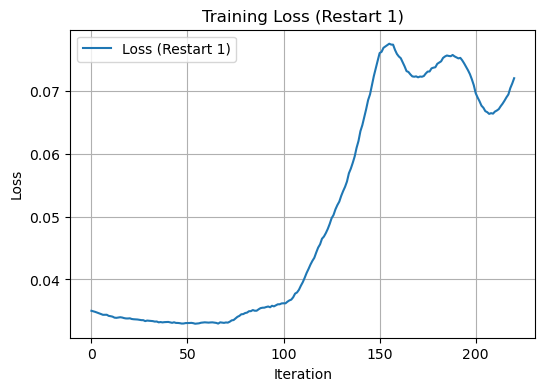

Initial Restart 2/15
Restart 2, Iteration 0, Loss: 0.04539991915225983
Restart 2, Iteration 50, Loss: 0.035701461136341095
Restart 2, Iteration 100, Loss: 0.03610648214817047
Restart 2, Iteration 150, Loss: 0.037730153650045395
Restart 2, Iteration 200, Loss: 0.036751165986061096
Early stopping at iteration 200 for restart 2


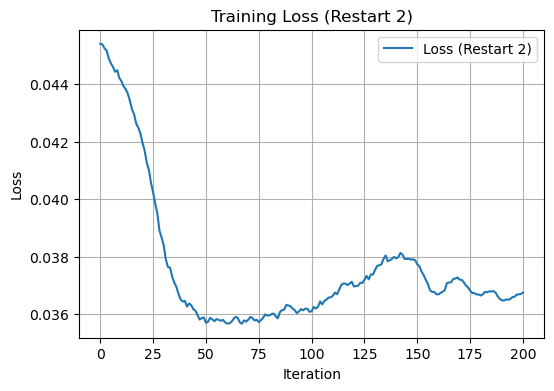

Initial Restart 3/15
Restart 3, Iteration 0, Loss: 0.04151272773742676
Restart 3, Iteration 50, Loss: 0.04055827856063843
Restart 3, Iteration 100, Loss: 0.03519350290298462
Restart 3, Iteration 150, Loss: 0.020042134448885918
Restart 3, Iteration 200, Loss: 0.02170027792453766
Early stopping at iteration 200 for restart 3


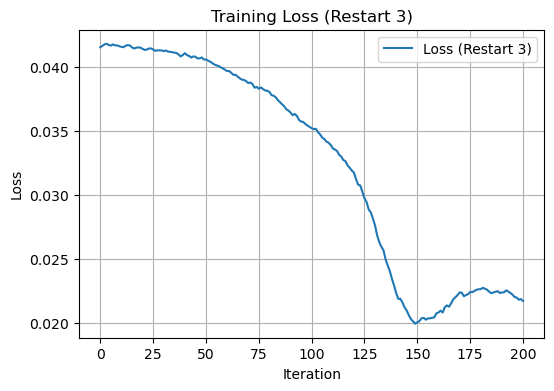

Initial Restart 4/15
Restart 4, Iteration 0, Loss: 0.04060085862874985
Restart 4, Iteration 50, Loss: 0.03972173109650612
Restart 4, Iteration 100, Loss: 0.039376337081193924
Restart 4, Iteration 150, Loss: 0.039491232484579086
Restart 4, Iteration 200, Loss: 0.040358178317546844
Early stopping at iteration 200 for restart 4


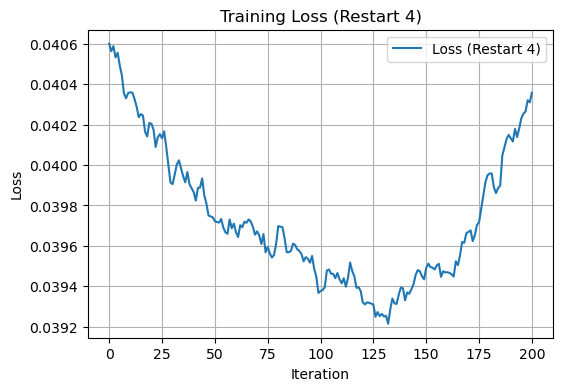

Initial Restart 5/15
Restart 5, Iteration 0, Loss: 0.04306397587060928
Restart 5, Iteration 50, Loss: 0.04282205179333687
Restart 5, Iteration 100, Loss: 0.04291040822863579
Restart 5, Iteration 150, Loss: 0.04182710871100426
Restart 5, Iteration 200, Loss: 0.04110366106033325
Early stopping at iteration 200 for restart 5


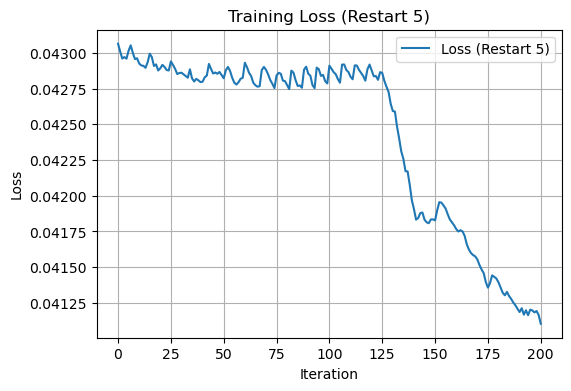

Initial Restart 6/15
Restart 6, Iteration 0, Loss: 0.04322823882102966
Restart 6, Iteration 50, Loss: 0.04462238401174545
Restart 6, Iteration 100, Loss: 0.0474160872399807
Restart 6, Iteration 150, Loss: 0.0544150210916996
Restart 6, Iteration 200, Loss: 0.08541429787874222
Early stopping at iteration 200 for restart 6


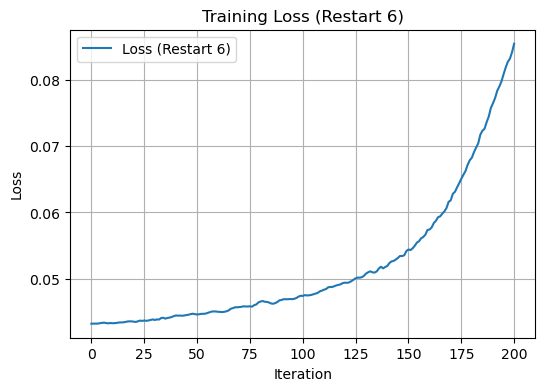

Initial Restart 7/15
Restart 7, Iteration 0, Loss: 0.04090725630521774
Restart 7, Iteration 50, Loss: 0.03501146659255028
Restart 7, Iteration 100, Loss: 0.03339749202132225
Restart 7, Iteration 150, Loss: 0.05198623612523079
Restart 7, Iteration 200, Loss: 0.06974925100803375
Early stopping at iteration 200 for restart 7


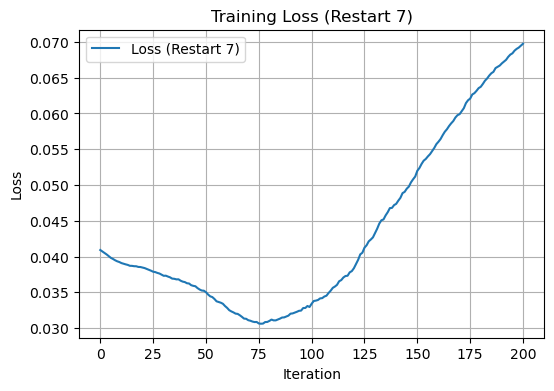

Initial Restart 8/15
Restart 8, Iteration 0, Loss: 0.042609404772520065
Restart 8, Iteration 50, Loss: 0.04352765530347824
Restart 8, Iteration 100, Loss: 0.047646306455135345
Restart 8, Iteration 150, Loss: 0.10137864947319031
Restart 8, Iteration 200, Loss: 0.1041824072599411
Early stopping at iteration 200 for restart 8


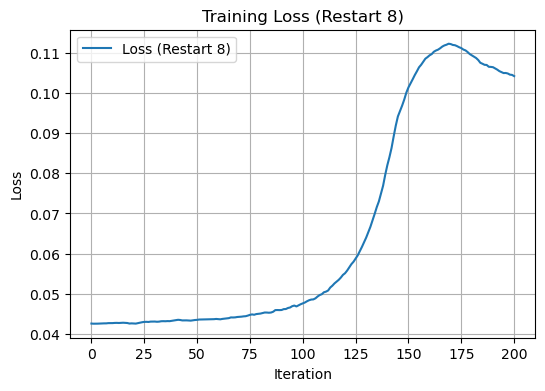

Initial Restart 9/15
Restart 9, Iteration 0, Loss: 0.03590098023414612
Restart 9, Iteration 50, Loss: 0.03591400757431984
Restart 9, Iteration 100, Loss: 0.03721108287572861
Restart 9, Iteration 150, Loss: 0.038149040192365646
Restart 9, Iteration 200, Loss: 0.0391322523355484
Early stopping at iteration 200 for restart 9


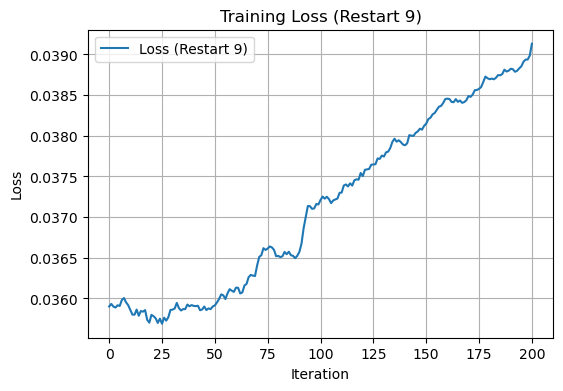

Initial Restart 10/15
Restart 10, Iteration 0, Loss: 0.038735389709472656
Restart 10, Iteration 50, Loss: 0.038003452122211456
Restart 10, Iteration 100, Loss: 0.0362124964594841
Restart 10, Iteration 150, Loss: 0.03537918999791145
Restart 10, Iteration 200, Loss: 0.034685518592596054
Early stopping at iteration 200 for restart 10


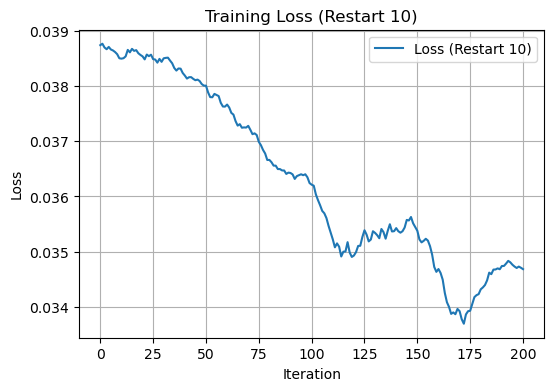

Initial Restart 11/15
Restart 11, Iteration 0, Loss: 0.040809717029333115
Restart 11, Iteration 50, Loss: 0.03853079304099083
Restart 11, Iteration 100, Loss: 0.026171214878559113
Restart 11, Iteration 150, Loss: 0.02987147495150566
Restart 11, Iteration 200, Loss: 0.03170691803097725
Early stopping at iteration 200 for restart 11


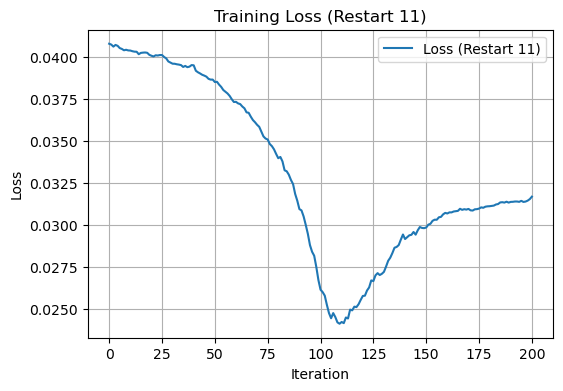

Initial Restart 12/15
Restart 12, Iteration 0, Loss: 0.04799897223711014
Restart 12, Iteration 50, Loss: 0.04547597095370293
Restart 12, Iteration 100, Loss: 0.03555222973227501
Restart 12, Iteration 150, Loss: 0.03513311222195625
Restart 12, Iteration 200, Loss: 0.034931886941194534
Early stopping at iteration 200 for restart 12


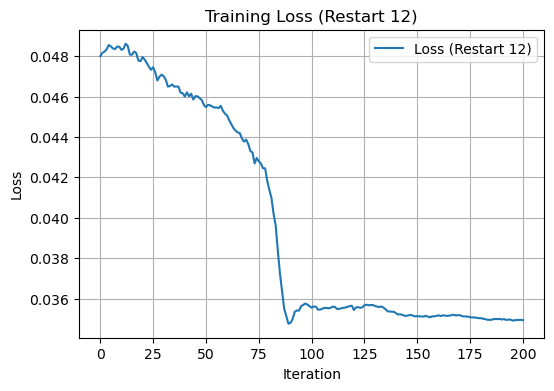

Initial Restart 13/15
Restart 13, Iteration 0, Loss: 0.035420339554548264
Restart 13, Iteration 50, Loss: 0.03417550027370453
Restart 13, Iteration 100, Loss: 0.034905798733234406
Restart 13, Iteration 150, Loss: 0.035405196249485016
Restart 13, Iteration 200, Loss: 0.035345401614904404
Early stopping at iteration 200 for restart 13


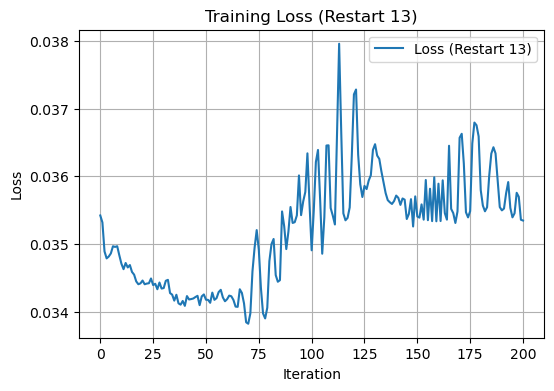

Initial Restart 14/15
Restart 14, Iteration 0, Loss: 0.03939147666096687
Restart 14, Iteration 50, Loss: 0.03668911010026932
Restart 14, Iteration 100, Loss: 0.03569930046796799
Restart 14, Iteration 150, Loss: 0.036901868879795074
Restart 14, Iteration 200, Loss: 0.0377388522028923
Early stopping at iteration 200 for restart 14


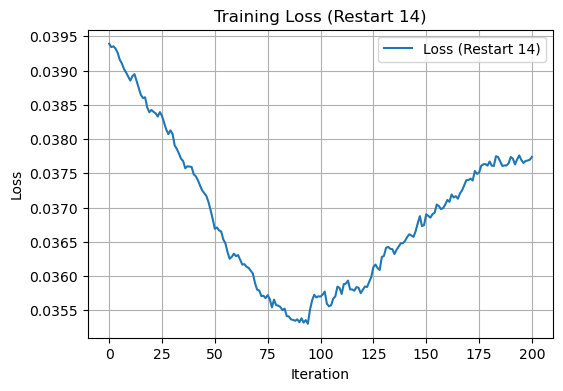

Initial Restart 15/15
Restart 15, Iteration 0, Loss: 0.039457883685827255
Restart 15, Iteration 50, Loss: 0.03607047721743584
Restart 15, Iteration 100, Loss: 0.035872265696525574
Restart 15, Iteration 150, Loss: 0.03760082274675369
Restart 15, Iteration 200, Loss: 0.03932858258485794
Early stopping at iteration 200 for restart 15


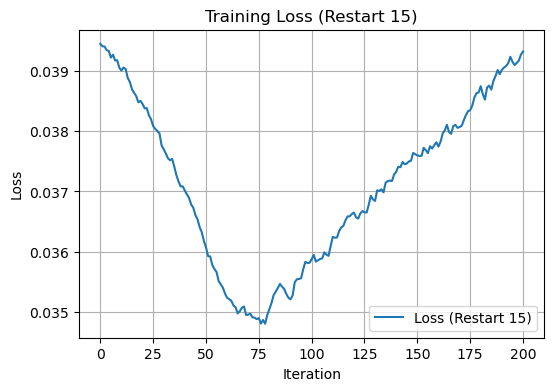

Best Initial Restart: 2 with Loss 0.02170027792453766
Refined Restart 1/5
Refined Restart 1, Iteration 0, Loss: 0.014446702785789967
Refined Restart 1, Iteration 50, Loss: 0.015953565016388893
Refined Restart 1, Iteration 100, Loss: 0.01567164808511734
Refined Restart 1, Iteration 150, Loss: 0.015646329149603844
Refined Restart 1, Iteration 200, Loss: 0.015987450256943703
Early stopping at iteration 200 for refined restart 1


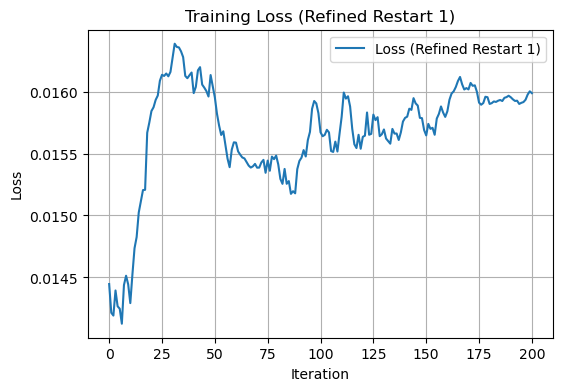

Refined Restart 2/5
Refined Restart 2, Iteration 0, Loss: 0.022092320024967194
Refined Restart 2, Iteration 50, Loss: 0.018668584525585175
Refined Restart 2, Iteration 100, Loss: 0.016450222581624985
Refined Restart 2, Iteration 150, Loss: 0.015616195276379585
Refined Restart 2, Iteration 200, Loss: 0.015846524387598038
Early stopping at iteration 200 for refined restart 2


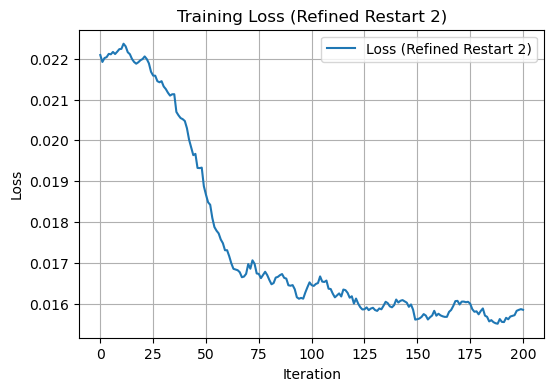

Refined Restart 3/5
Refined Restart 3, Iteration 0, Loss: 0.02427148073911667
Refined Restart 3, Iteration 50, Loss: 0.022764425724744797
Refined Restart 3, Iteration 100, Loss: 0.01639479771256447
Refined Restart 3, Iteration 150, Loss: 0.016062689945101738
Refined Restart 3, Iteration 200, Loss: 0.01578172668814659
Early stopping at iteration 200 for refined restart 3


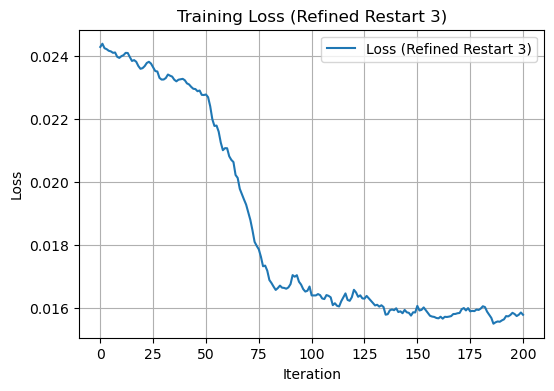

Refined Restart 4/5
Refined Restart 4, Iteration 0, Loss: 0.022252826020121574
Refined Restart 4, Iteration 50, Loss: 0.015732429921627045
Refined Restart 4, Iteration 100, Loss: 0.016457736492156982
Refined Restart 4, Iteration 150, Loss: 0.0163150392472744
Refined Restart 4, Iteration 200, Loss: 0.015518708154559135
Early stopping at iteration 200 for refined restart 4


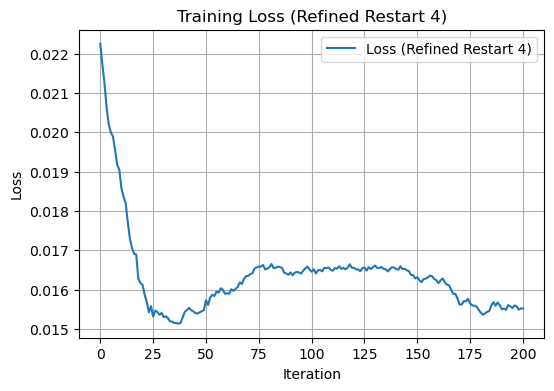

Refined Restart 5/5
Refined Restart 5, Iteration 0, Loss: 0.026218807324767113
Refined Restart 5, Iteration 50, Loss: 0.0223532747477293
Refined Restart 5, Iteration 100, Loss: 0.02042909525334835
Refined Restart 5, Iteration 150, Loss: 0.016293933615088463
Refined Restart 5, Iteration 200, Loss: 0.016080621629953384
Early stopping at iteration 200 for refined restart 5


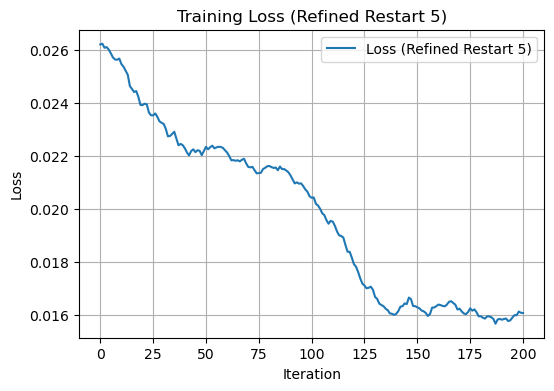

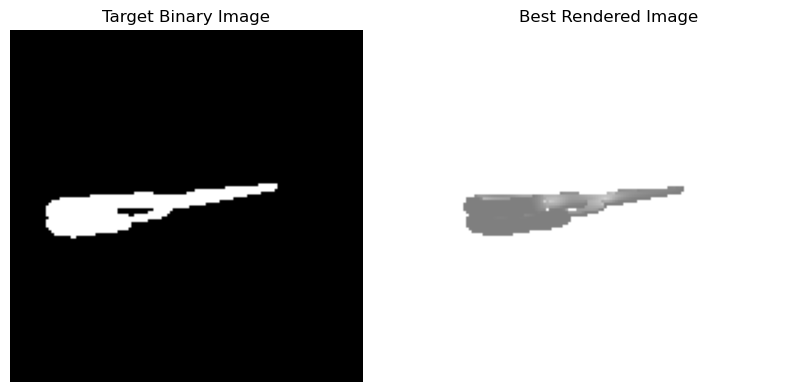

Best Training Results:
Lowest Loss: 0.015518708154559135
Best Camera Position: [ 19.555128    4.0911517 -19.839806 ]


In [34]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# Function to generate a random camera position within a safe distance
def random_camera_position(min_distance, max_distance, device):
    # Generate a random distance within the specified range
    distance = np.random.uniform(min_distance, max_distance)
    
    # Generate random azimuth and elevation angles
    azimuth = np.random.uniform(0, 360)  # Degrees
    elevation = np.random.uniform(-90, 90)  # Degrees
    
    # Convert spherical coordinates to Cartesian coordinates
    x = distance * np.cos(np.radians(elevation)) * np.cos(np.radians(azimuth))
    y = distance * np.cos(np.radians(elevation)) * np.sin(np.radians(azimuth))
    z = distance * np.sin(np.radians(elevation))
    
    # Return the camera position as a torch tensor
    return torch.tensor([x, y, z], device=device, dtype=torch.float32)

# Function to generate a new camera position near a given position
def random_nearby_position(reference_position, deviation, device):
    noise = np.random.uniform(-deviation, deviation, size=(3,))
    new_position = reference_position.cpu().numpy() + noise
    return torch.tensor(new_position, device=device, dtype=torch.float32)

# Safe camera position range
min_distance = 40.0  # Closest the camera can be
max_distance = 50.0  # Farthest the camera can be
nearby_deviation = 5.0  # Deviation for secondary restarts

# Training hyperparameters
num_initial_restarts = 15
num_refined_restarts = 5
num_iterations_min = 200
num_iterations_max = 400
patience = 20  # Early stopping patience
significant_improvement = 0.001  # Change threshold for continued training

best_loss = float('inf')
best_camera_position = None
best_rendered_image = None

all_restart_results = []

# Perform initial random restarts
for restart in range(num_initial_restarts):
    print(f"Initial Restart {restart + 1}/{num_initial_restarts}")
    
    # Randomize the initial camera position
    model.camera_position.data = random_camera_position(min_distance, max_distance, device)

    # Initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    loss_values = []
    prev_loss = float('inf')
    no_improve_counter = 0

    # Training loop with early stopping and adaptive iteration limit
    for i in range(num_iterations_max):
        optimizer.zero_grad()
        loss, rendered_image = model()  # Forward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()

        # Store loss for plotting
        loss_values.append(loss.item())

        # Print progress every 50 iterations
        if i % 50 == 0 or i == num_iterations_max - 1:
            print(f"Restart {restart + 1}, Iteration {i}, Loss: {loss.item()}")

        # Early stopping check
        if loss.item() >= prev_loss - significant_improvement:
            no_improve_counter += 1
        else:
            no_improve_counter = 0  # Reset counter if improvement is significant

        prev_loss = loss.item()

        if no_improve_counter >= patience and i >= num_iterations_min:
            print(f"Early stopping at iteration {i} for restart {restart + 1}")
            break

    # Save restart results
    restart_result = {
        'restart_id': restart,
        'final_loss': loss_values[-1],
        'camera_position': model.camera_position.data.clone(),
        'loss_values': loss_values
    }
    all_restart_results.append(restart_result)

    # Update best model
    if loss_values[-1] < best_loss:
        best_loss = loss_values[-1]
        best_camera_position = model.camera_position.data.clone()
        best_rendered_image = rendered_image.clone()

    # Plot the loss curve for this restart
    plt.figure(figsize=(6, 4))
    plt.plot(loss_values, label=f"Loss (Restart {restart + 1})")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title(f"Training Loss (Restart {restart + 1})")
    plt.legend()
    plt.grid(True)
    plt.show()

# Identify the best initial restart
best_initial_restart = min(all_restart_results, key=lambda x: x['final_loss'])
print(f"Best Initial Restart: {best_initial_restart['restart_id']} with Loss {best_initial_restart['final_loss']}")

# Perform focused refinement near the best initial restart
for restart in range(num_refined_restarts):
    print(f"Refined Restart {restart + 1}/{num_refined_restarts}")

    # Generate a nearby random position
    model.camera_position.data = random_nearby_position(best_initial_restart['camera_position'], nearby_deviation, device)

    # Initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)  # Lower LR for fine-tuning
    loss_values = []
    prev_loss = float('inf')
    no_improve_counter = 0

    # Training loop with early stopping and adaptive iteration limit
    for i in range(num_iterations_max):
        optimizer.zero_grad()
        loss, rendered_image = model()  # Forward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()

        # Store loss for plotting
        loss_values.append(loss.item())

        # Print progress every 50 iterations
        if i % 50 == 0 or i == num_iterations_max - 1:
            print(f"Refined Restart {restart + 1}, Iteration {i}, Loss: {loss.item()}")

        # Early stopping check
        if loss.item() >= prev_loss - significant_improvement:
            no_improve_counter += 1
        else:
            no_improve_counter = 0  # Reset counter if improvement is significant

        prev_loss = loss.item()

        if no_improve_counter >= patience and i >= num_iterations_min:
            print(f"Early stopping at iteration {i} for refined restart {restart + 1}")
            break

    # Update best model
    if loss_values[-1] < best_loss:
        best_loss = loss_values[-1]
        best_camera_position = model.camera_position.data.clone()
        best_rendered_image = rendered_image.clone()

    # Plot the loss curve for this restart
    plt.figure(figsize=(6, 4))
    plt.plot(loss_values, label=f"Loss (Refined Restart {restart + 1})")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title(f"Training Loss (Refined Restart {restart + 1})")
    plt.legend()
    plt.grid(True)
    plt.show()

# Use the best camera position for final visualization
model.camera_position.data = best_camera_position

# Render the final image with the best camera position
final_rendered_image = phong_renderer(
    meshes_world=model.meshes.clone(),
    R=look_at_rotation(model.camera_position[None, :], device=model.device),
    T=-torch.bmm(
        look_at_rotation(model.camera_position[None, :], device=model.device).transpose(1, 2),
        model.camera_position[None, :, None]
    )[:, :, 0]
)[0, ..., :3].detach().cpu().numpy()

# Display the best result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(model.image_ref.detach().cpu().squeeze(), cmap="gray")
plt.title("Target Binary Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(final_rendered_image)
plt.title("Best Rendered Image")
plt.axis("off")
plt.show()

# Print the best results
print("Best Training Results:")
print(f"Lowest Loss: {best_loss}")
print(f"Best Camera Position: {best_camera_position.cpu().numpy()}")

In [35]:
# Define the scale factor to convert mesh units to the desired unit system
scale_factor = 1.0  # Adjust as needed

# Step 1: Compute the bounding box dimensions of the target mesh
verts_target = clip_mesh.verts_packed() * scale_factor  # Apply the scale factor
bbox_min = verts_target.min(dim=0).values  # Min corner of the bounding box
bbox_max = verts_target.max(dim=0).values  # Max corner of the bounding box
bbox_dimensions = bbox_max - bbox_min  # Dimensions of the bounding box (in desired units)

# Step 2: Apply the final camera transformation to the mesh vertices
R_f = look_at_rotation(best_camera_position[None, :], device=model.device)  # Final rotation matrix
T_f = -torch.bmm(R_f.transpose(1, 2), best_camera_position[None, :, None])[:, :, 0]  # Final translation vector
print(f"Predicted R = {R_f}")
print(f"Predicted T = {T_f}")

# Transform the vertices of the final mesh
verts_final = torch.matmul(verts_target, R_f.transpose(1, 2)[0]) + T_f[0]  # Apply R and T

# Transform the target vertices to the camera's view space
verts_target_transformed = torch.matmul(verts_target, R_t.transpose(1, 2)[0]) + T_t[0]

# Step 3: Compute deviations between transformed target and final vertices
deviations = torch.norm(verts_target_transformed - verts_final, dim=1)  # Euclidean distance for each vertex
max_deviation = deviations.max().item()  # Maximum deviation (in desired units)

# Step 4: Report the results
print("Bounding Box Dimensions (in desired units):", bbox_dimensions.cpu().numpy())
print(f"Maximum Deviation (in desired units): {max_deviation}")
print("verts_target_transformed:")
print(verts_target_transformed)
print("verts_final:")
print(verts_final)


Predicted R = tensor([[[ 0.7122, -0.1020, -0.6945],
         [-0.0000,  0.9894, -0.1453],
         [ 0.7020,  0.1035,  0.7046]]], device='cuda:0')
Predicted T = tensor([[9.5367e-07, 4.7684e-07, 2.8156e+01]], device='cuda:0')
Bounding Box Dimensions (in desired units): [24.488085   2.680991   6.3696203]
Maximum Deviation (in desired units): 4.723174571990967
verts_target_transformed:
tensor([[  7.4819,   1.3243,  31.0495],
        [  7.3343,   1.4809,  31.3149],
        [  7.1460,   1.4743,  31.6163],
        ...,
        [-10.3455,   0.7214,  24.3452],
        [-10.3831,   0.7209,  24.3720],
        [-10.4187,   0.7207,  24.4051]], device='cuda:0')
verts_final:
tensor([[ 7.0707,  0.9876, 30.9602],
        [ 6.8751,  1.1784, 31.1655],
        [ 6.6182,  1.2129, 31.4087],
        ...,
        [-8.5282,  0.7484, 20.0173],
        [-8.5711,  0.7528, 20.0336],
        [-8.6137,  0.7580, 20.0565]], device='cuda:0')


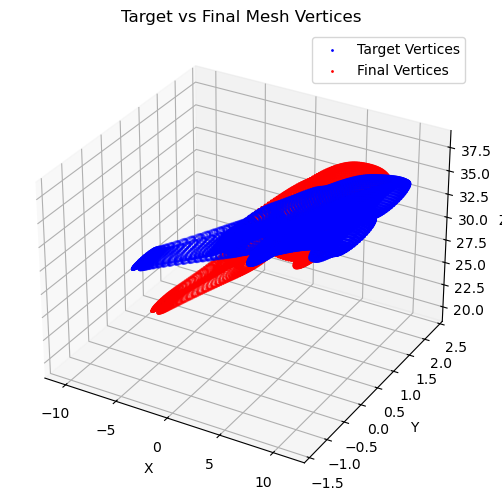

In [36]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Convert to NumPy arrays for plotting
verts_target_np = verts_target_transformed.cpu().numpy()
verts_final_np = verts_final.cpu().numpy()

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the target mesh vertices
ax.scatter(
    verts_target_np[:, 0], verts_target_np[:, 1], verts_target_np[:, 2],
    c='blue', label='Target Vertices', s=1
)

# Plot the final mesh vertices
ax.scatter(
    verts_final_np[:, 0], verts_final_np[:, 1], verts_final_np[:, 2],
    c='red', label='Final Vertices', s=1
)

ax.set_title("Target vs Final Mesh Vertices")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.show()
